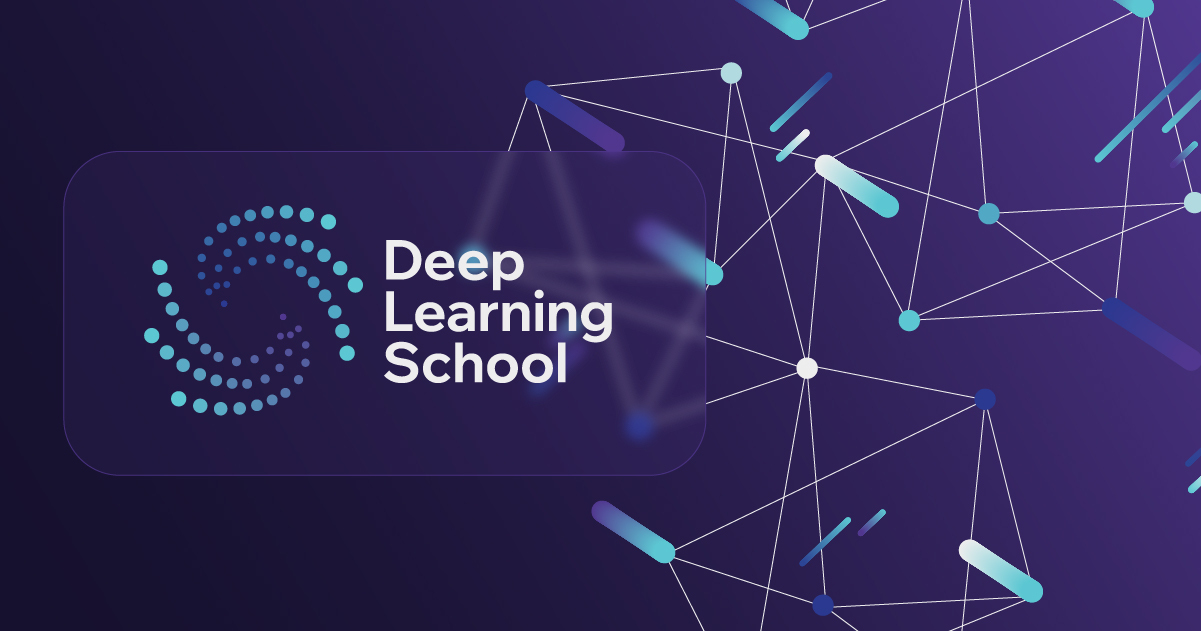

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Self-Supervised Learning in Audio</b></h3>


# Self-Supervised Learning in Audio

## Multi-Format Contrastive Learning of Audio Representations

The core idea of this approach is to learn robust audio embeddings by contrasting
different *formats* (or views) of the same audio sample.  
For example, one branch may encode the **raw waveform (1D)** while another encodes
its **spectrogram (2D)**.  

By applying a contrastive loss (InfoNCE), the model is trained to:
- **Pull together** embeddings from different formats of the same audio,
- **Push apart** embeddings from different audio samples.  

This multi-format setup encourages the encoder to capture **shared semantic content**
across input representations, leading to more general and transferable audio features.

[Multi-Format Contrastive Learning of Audio Representations paper](https://arxiv.org/pdf/2103.06508)

[CLAR](https://arxiv.org/pdf/2010.09542)

[CLAR github implementation](https://github.com/HondamunigePrasannaSilva/CLAR?tab=readme-ov-file)


clar.png

## AudioMNIST

AudioMNIST: it contains 60 speakers pronouncing digits from 0 to 9. Our main task is digit classification, but such data also allows us to explore aspects of voice biometrics.

In [ ]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30137, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 30137 (delta 9), reused 4 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30137/30137), 944.54 MiB | 22.17 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (30018/30018), done.


In [ ]:
!mkdir models

In [ ]:
import os
import random
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from IPython.display import Audio
from pathlib import Path
from omegaconf import DictConfig

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm.notebook import tqdm
from torch.utils.data import Subset, DataLoader
from torchaudio import transforms
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", module="torchaudio._backend")

plt.rcParams.update({'font.size': 14})

In [ ]:
#check for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device:", device)

Available device: cuda


In [ ]:
root = 'AudioMNIST/data'
rand_speaker = random.choice(os.listdir(root))
rand_audio = random.choice(os.listdir(os.path.join(root, rand_speaker)))
print(f'Speaker #{rand_speaker}, class #{rand_audio[0]}')

waveform, sample_rate = torchaudio.load(
    os.path.join(root, rand_speaker, rand_audio), normalize=True
)
print(f'Sample rate: {sample_rate}, waveform shape: {waveform.shape}')
Audio(waveform, rate=sample_rate)

Speaker #46, class #5
Sample rate: 48000, waveform shape: torch.Size([1, 32425])


In [ ]:
new_sample_rate = 16000
resample = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resample(waveform)
Audio(resampled_waveform, rate=new_sample_rate)

In [ ]:
class LogMelSpectrogram(T.MelSpectrogram):
    def __init__(self, eps=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def forward(self, waveform):
        return (super().forward(waveform) + self.eps).log()

Spectrogram shape: torch.Size([64, 55])
Values range: ((tensor(-16.7511), tensor(-2.1593)))


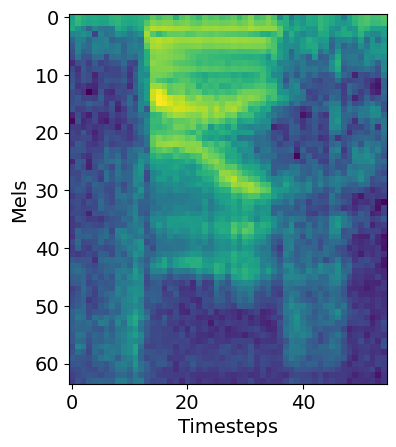

In [ ]:
spectrogram = LogMelSpectrogram(sample_rate=16000, n_mels=64)
logmel_spec = spectrogram(resampled_waveform.squeeze())
print(f'Spectrogram shape: {logmel_spec.shape}')
print(f'Values range: ({logmel_spec.min(), logmel_spec.max()})')

plt.imshow(logmel_spec.numpy())
plt.ylabel('Mels')
plt.xlabel('Timesteps')
plt.show()

## Dataset
First load wav files and labels for AudioMNIST and implement collator function

In [ ]:

class AudioMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, root, sr=16000):
        self.root = root
        self.sr = sr
        self.items = self.list_wavs_and_labels(root)

    def __len__(self):
      return len(self.items)

    def list_wavs_and_labels(self, root: str):
      base = Path(root)
      speakers = sorted([p for p in base.iterdir() if p.is_dir()])
      items = []
      for sp in speakers:
          for wav in sorted(sp.glob("**/*.wav")):
              # filename e.g., "9_10_0_0_1.wav" (digit_speaker_..)
              name = wav.stem.split("_")
              digit = int(name[0])
              speaker_id = sp.name
              items.append((str(wav), digit, speaker_id))
      return items

    def load_wav(self, path):
        wav, sr = torchaudio.load(path)  # [C, T]
        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)
        wav = wav.mean(dim=0, keepdim=True)  # mono [1, T]
        return wav

    def __getitem__(self, idx):
        path, label, speaker = self.items[idx]
        wav = self.load_wav(path)

        return wav, label

def collate(batch):
    wavs, labels = zip(*batch)
    wavs = nn.utils.rnn.pad_sequence([w.squeeze(0).t() for w in wavs], batch_first=True)  # [B, Tw, 1]? we transposed; fix:
    wavs = nn.utils.rnn.pad_sequence([w.squeeze(0) for w in wavs], batch_first=True)  # [B, T]
    labels = torch.tensor(labels, dtype=torch.long)
    return wavs, labels


# Ensure data loading correctly
_test_dataset = AudioMNISTDataset(root)
_test_dataset[0]

(tensor([[0.0003, 0.0005, 0.0004,  ..., 0.0005, 0.0005, 0.0006]]), 0)

## Data Split
Split into train and eval by speaker: out of 60 speakers in total, 12 are assigned to the eval set.

In [ ]:
def split_indices_by_speaker(dataset: AudioMNISTDataset, test_speakers: set):
    train_idxs = []
    test_idxs = []
    for idx, (_, _, spk) in enumerate(dataset.items):
        if spk in test_speakers:
            test_idxs.append(idx)
        else:
            train_idxs.append(idx)
    return train_idxs, test_idxs


# Split dataset by speakers
NUM_TEST_SPEAKERS = 12
full_ds = AudioMNISTDataset(root=root)
all_speakers = sorted({spk for (_, _, spk) in full_ds.items})
valid_speakers = set(all_speakers[-NUM_TEST_SPEAKERS:])
train_idxs, valid_idxs = split_indices_by_speaker(full_ds, valid_speakers)
train_ds = Subset(full_ds, train_idxs)
valid_ds = Subset(full_ds, valid_idxs)


## Convolutional encoders

---

#### **1. ResNet1D – for raw waveforms**
- **Input:** `[batch, 1, time]`  
- **First layer:** `Conv1d(7, stride=2)` → BatchNorm → ReLU → MaxPool1d  
- **Residual blocks:** `[2, 2, 2, 2]` blocks with channels `[64, 128, 256, 512]`  
- **Each block:** `Conv1d(1x1)` + `Conv1d(3x3)` with skip connection  
- **Output:** Global average pooled feature `[batch, 512, 1]`  

This encoder *slides filters along the time axis* to capture **temporal patterns** in raw waveforms.

---

#### **2. ResNet2D – for spectrograms**
- **Input:** `[batch, channels, height, width]`  
- **First layer:** `Conv2d(7x7, stride=2)` → BatchNorm → ReLU → MaxPool2d  
- **Residual blocks:** `[2, 2, 2, 2]` blocks with channels `[64, 128, 256, 512]`  
- **Each block:** `Conv2d(1x1)` + `Conv2d(3x3)` with skip connection  
- **Output:** Global average pooled feature `[batch, 512, 1, 1]`  

This encoder *slides filters along time and frequency dimensions* to capture **spectro-temporal patterns** in spectrograms.

---


In [ ]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None,stride=1):
        super(block, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()


    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class ResNet1D(nn.Module):
    # Resnet 18 [2, 2, 2, 2]
    def __init__(self, block):
        super(ResNet1D, self).__init__()
        # for resnet18
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64
        self.conv1 = nn.Conv1d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(block, layers[0], 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(output_size=1)


        # size after avgpool = [32, 512, 1]

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        #x = x.reshape(x.shape[0], -1)
        #x = self.fc(x)

        return x



    def _make_layer(self, block, num_residual_block, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1:
            identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels,
                                                out_channels*self.expansion,
                                                kernel_size=1,
                                                stride=stride,
                                                bias=False),
                                                nn.BatchNorm1d(out_channels*self.expansion),
                                                )
        layers.append(
            block(self.in_channels,out_channels, identity_downsample, stride)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_residual_block):
            layers.append(block(self.in_channels,out_channels ))

        return nn.Sequential(*layers)



def CreateResNet1D():
    return ResNet1D(block)



class block_resnet2d(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None,stride=1):
        super(block_resnet2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()


    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x

class ResNet(nn.Module):
    # Resnet 18 [2, 2, 2, 2]
    def __init__(self, block, image_channels):
        super(ResNet, self).__init__()
        # for resnet18
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(block, layers[0], 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))


    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        return x



    def _make_layer(self, block, num_residual_block, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,
                                                out_channels*self.expansion,
                                                kernel_size=1,
                                                stride=stride,
                                                bias=False),
                                                nn.BatchNorm2d(out_channels*self.expansion),
                                                )
        layers.append(
            block(self.in_channels,out_channels, identity_downsample, stride)
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_residual_block):
            layers.append(block(self.in_channels,out_channels ))

        return nn.Sequential(*layers)



def CreateResNet2D(img_channels=3):
    return ResNet(block_resnet2d, image_channels=img_channels)



## Implement model

In [ ]:
class Net(nn.Module):

    def __init__(self, img_channels = 1, num_classes = 35):
        super(Net, self).__init__()
        ####################### ENCODER ###################################
        self.resnet_1D = CreateResNet1D()
        self.resnet_2D = CreateResNet2D(img_channels=img_channels)

        self.output = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

        ####################################################################

    def forward(self, input_spectogram, input_audio):
        """
            resnet2d and resnet1d output is [BS, 512, 1, 1]
            Output:
                - audio_emb, specs_emb used for contrastive loss
                - audio, spectograms used for Evaluation layer
                - output used for semi supervised - cross entropy
        """

        audio = self.resnet_1D(input_audio)
        audio = audio.squeeze()
        spectograms = self.resnet_2D(input_spectogram)
        spectograms = spectograms.squeeze()

        audio_emb = self.output(audio)
        specs_emb = self.output(spectograms)

        return audio_emb, specs_emb, audio, spectograms


class EvaluationHead(nn.Module):
    """
    Linear classifier head
    """
    def __init__(self, num_classes = 35):
        super(EvaluationHead, self).__init__()

        self.evaluation = nn.Sequential(
                    nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x = self.evaluation(x)
        return x

## Contrastive loss

This loss encourages *positive pairs* (two different augmented views of the same input) to have high similarity,
while pushing apart *negative pairs* (different inputs in the same batch).


Let $ z_i, z_j $ be two normalized embeddings of the same sample, and let
$ \text{sim}(u, v) = \frac{u \cdot v}{\|u\|\|v\|} $ be cosine similarity.  
The InfoNCE loss for a positive pair is:

$$
\ell_{i,j} = - \log
\frac{\exp\left( \text{sim}(z_i, z_j) / \tau \right)}
{\sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp\left( \text{sim}(z_i, z_k) / \tau \right)}
$$

where:
- $ \tau $ is the temperature parameter, controlling sharpness of similarities.
- $ N $ is the batch size (each sample contributes 2 views, so there are $ 2N $ embeddings).
- The denominator includes all positives and negatives except self-comparisons.

The final loss averages over all positive pairs in the batch.

**Practical notes:**
- Normalization (`F.normalize`) ensures cosine similarity is well-defined.
- Larger batch sizes yield more negative samples, improving contrastive learning.
- Temperature $ \tau\ $ strongly affects training stability; common values are in `[0.05, 0.5]`.
- This implementation builds a full similarity matrix, masks out self-similarities,
  and computes the InfoNCE objective across all 2N views.


In [ ]:
def device_as(t1, t2):
   return t1.to(t2.device)

class ContrastiveLoss(nn.Module):
  def __init__(self, temperature=0.5):
    super().__init__()
    self.temperature = temperature

  def calc_similarity_batch(self, a, b):
    rep = torch.cat([a,b])
    return F.cosine_similarity(rep.unsqueeze(1), rep.unsqueeze(0), dim=2)

  def forward(self, proj_1, proj_2):
    batch_size = proj_1.shape[0]
    z_i = F.normalize(proj_1, p=2, dim=1)
    z_j = F.normalize(proj_2, p=2, dim=1)

    similarity_matrix = self.calc_similarity_batch(z_i, z_j)

    #######
    #aa#ab#
    #######
    #ba#bb#
    #######

    sim_ij = torch.diag(similarity_matrix, batch_size)
    sim_ji = torch.diag(similarity_matrix, -batch_size)

    positives = torch.cat([sim_ij, sim_ji])

    nominator = torch.exp(positives / self.temperature)

    mask = (~torch.eye(batch_size*2, batch_size*2).bool()).float()
    mask = device_as(mask, similarity_matrix)

    denominator = mask * torch.exp(similarity_matrix / self.temperature)
    all_losses = -torch.log(nominator / torch.sum(denominator))
    loss = torch.sum(all_losses) / (2*batch_size)

    return loss




## Augmentations

In order to improve the robustness of our models, we apply data augmentations.
Augmentations modify the input examples in different ways, which helps the model
generalize better and not overfit to specific details of the training data.

Some augmentations have only a mild effect on the input, while others can be
quite strong and significantly change the appearance of the signal. Using a mix
of weaker and stronger transformations usually leads to better performance, as
the model learns to be invariant to a variety of perturbations.

The figure below illustrates how augmentations can alter both waveforms and their
spectrogram representations, showing the range of possible modifications the model
is trained to handle.


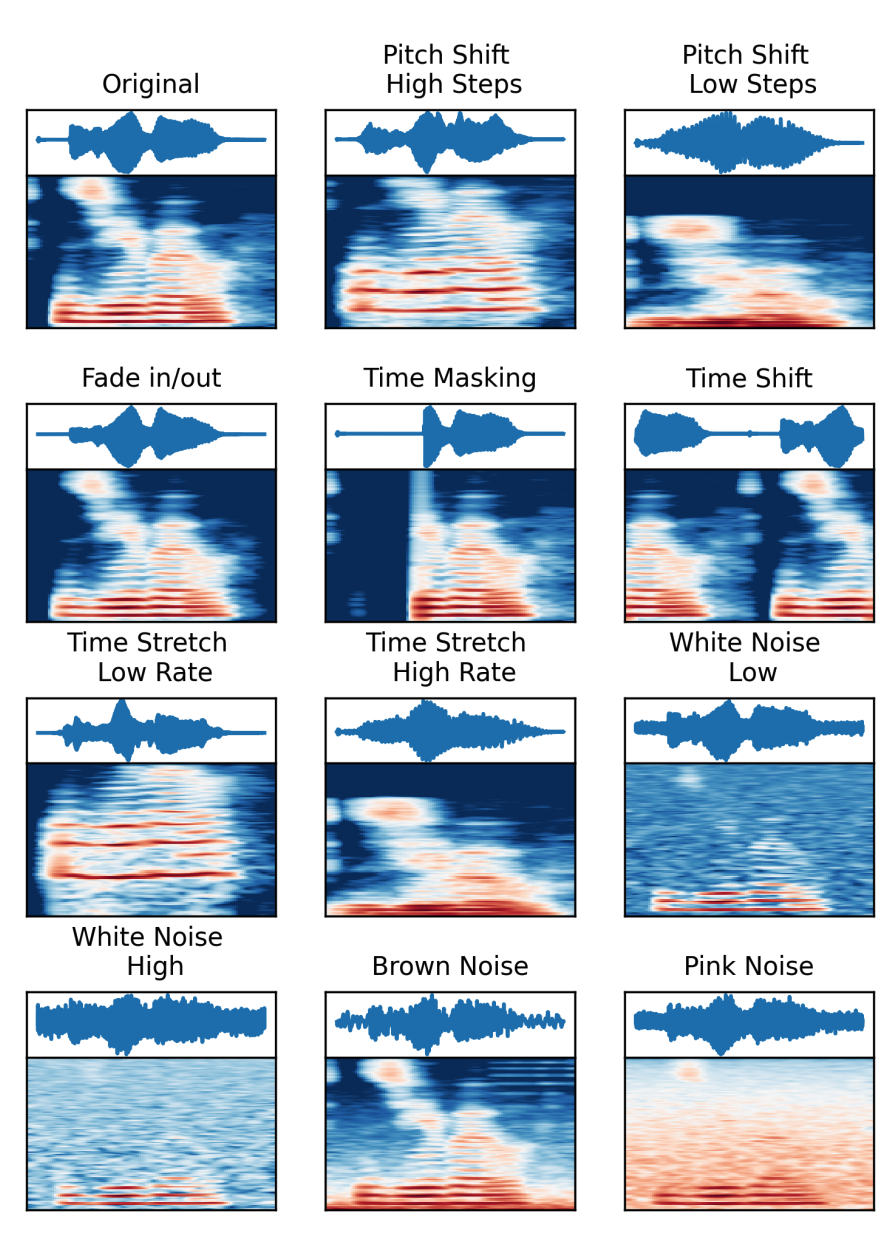

The figure below shows a heatmap of model accuracy when applying pairs of augmentations.
Results are reported separately for the 1D encoder (waveforms) and the 2D encoder (spectrograms).

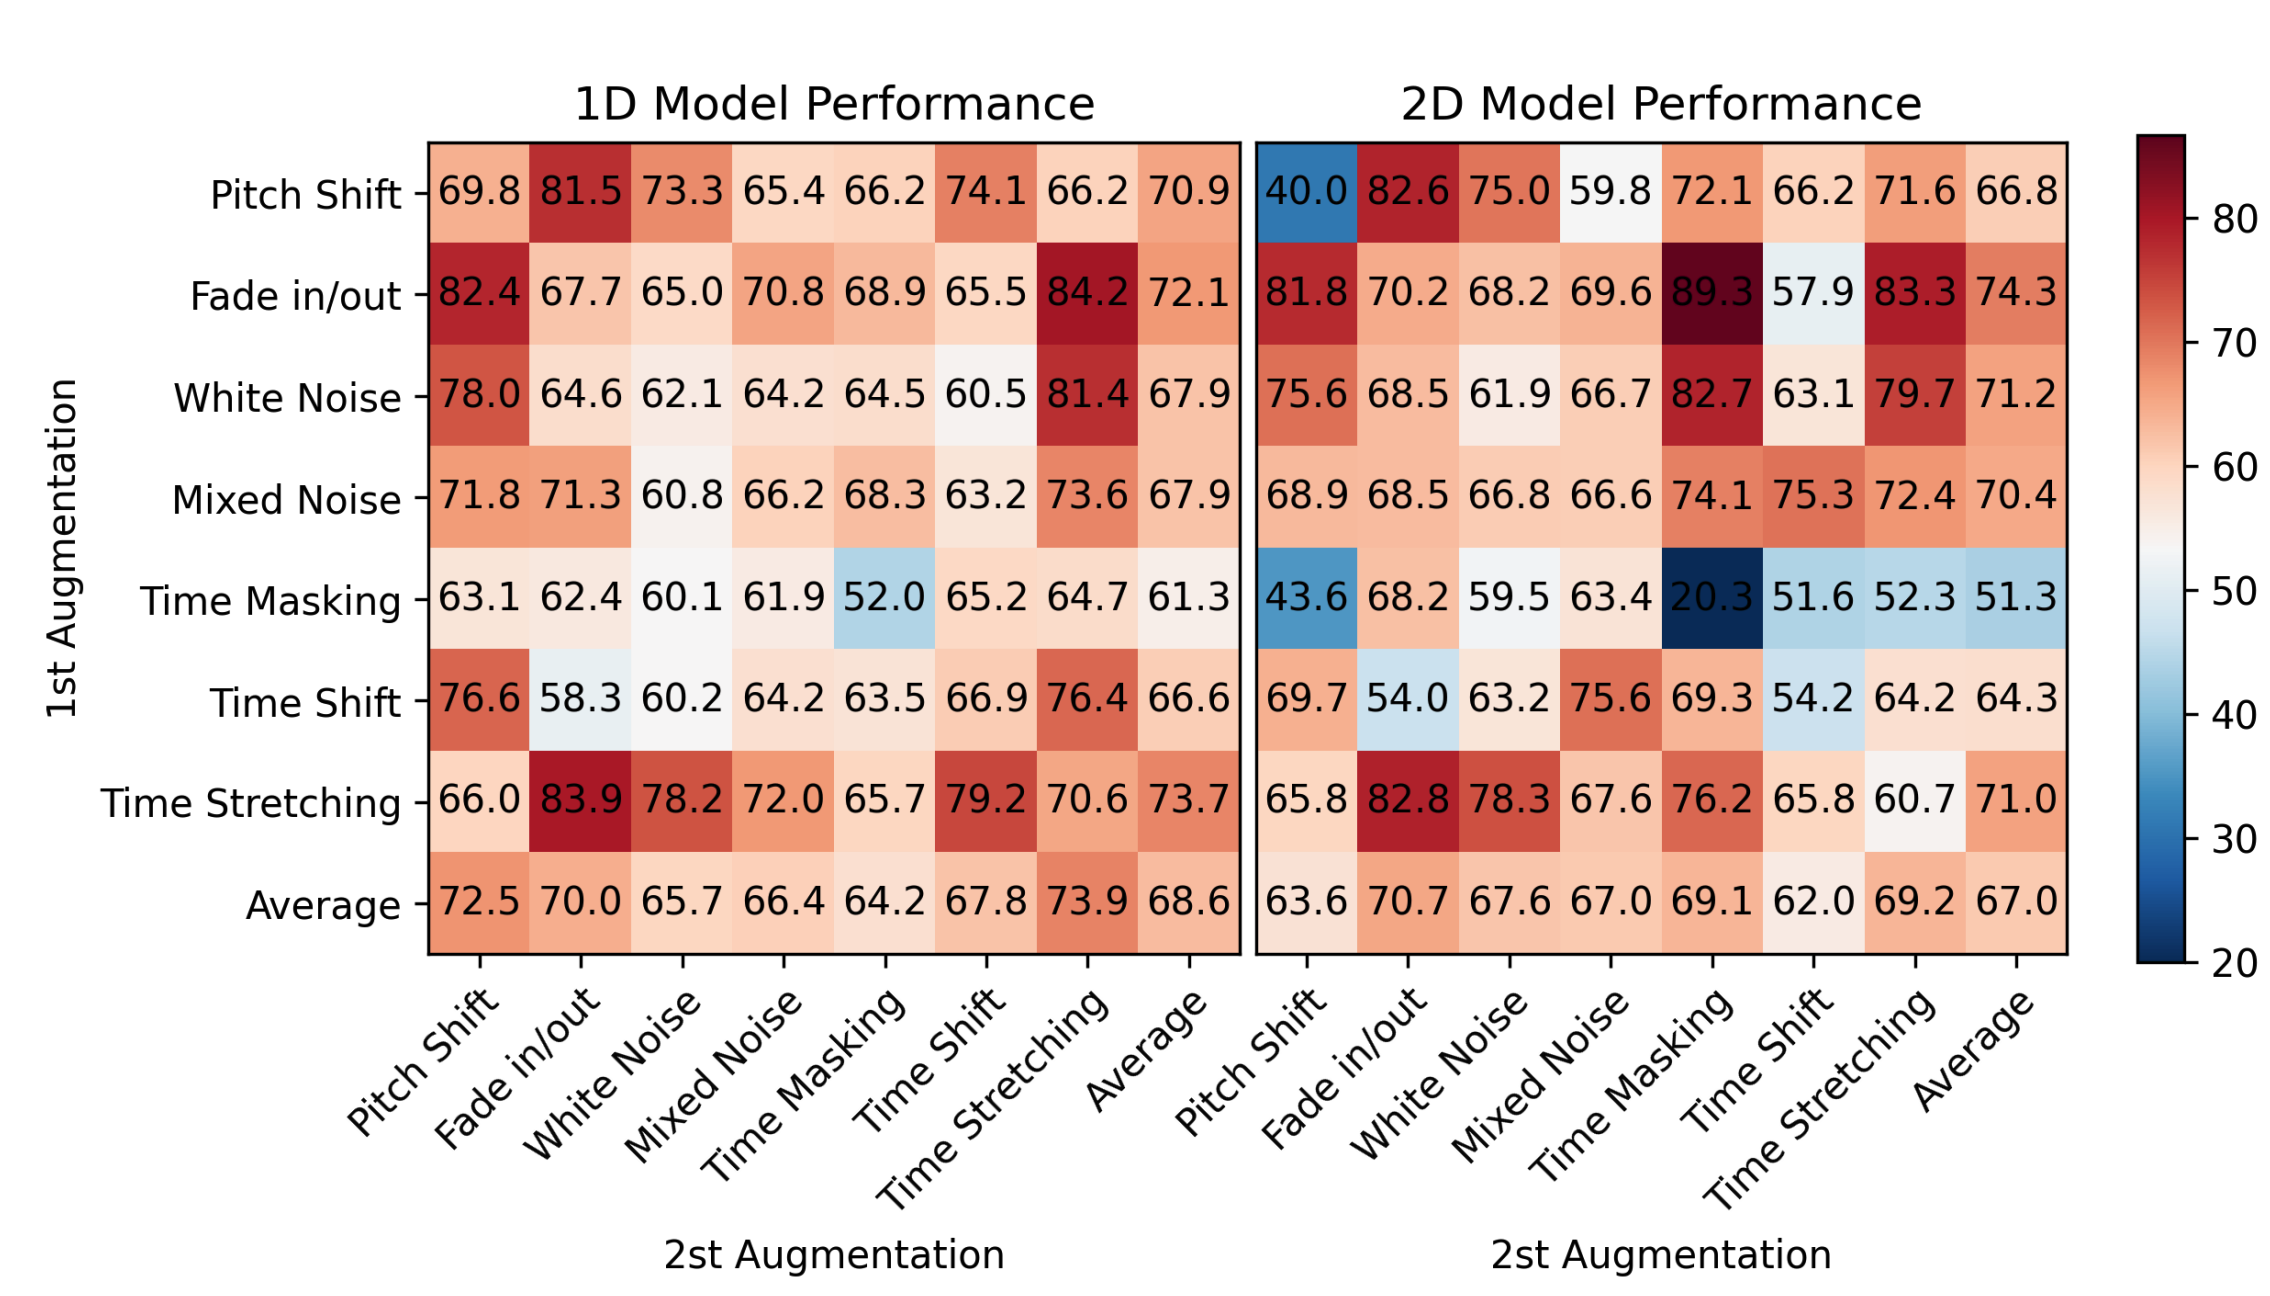

In [ ]:
def pitchshift(audio, SAMPLE_RATE=16000, shift = 2):
    """
    Pitch Shift (PS): randomly raises or lowers the pitch of the audio signal.\n
    Based on experimental observation,we found the range of pitch shifts that main-tained\n
    the overall coherency of the input audio was in the range [-15, 15] semitones.

    Attributes:
    - :param audio: audio tensor
    - :param SAMPLE_RATE: Sample rate, default=16000
    - :param shift: Pitch shift
    - :return: describe what it returns
    """
    assert audio != None, "audio should not be None"
    transform = transforms.PitchShift(sample_rate=SAMPLE_RATE, n_steps=shift)
    waveform_shift = transform(audio)
    return waveform_shift


def fade_in_out(audio):
    """
    Fade in/out (FD): gradually increases/decreases the intensity of the audio in the\n
    beginning/end of the audio signal.\n
    The degree of the fade was either linear, logarithmic or exponential (applied\n
    with uniform probability of 1/3). The size of the fade for either side of the\n
    audio signal could at maximum reach half of the audio signal. The size of the\n
    fade was another random parameter picked for each sample.
    """
    assert audio != None, "audio should not be None"
    _fade_shape = ['linear', 'logarithmic', 'exponential']
    _fade_size = [i for i in range(1, int(audio.shape[2]/2))]

    transform = transforms.Fade(fade_in_len=random.choice(_fade_size), fade_out_len=random.choice(_fade_size), fade_shape=random.choice(_fade_shape))
    waveform_fade_in_out = transform(audio)
    return waveform_fade_in_out

def add_white_noise_(signal, noise_level):
    """
    Noise Injection: mix the audio signal with random white, brown and pink noise.\n
    In our implementation, the intensity of the noise signal was randomly selected based\n
    on the strength of signal-to-noise ratio. Applied white, brown, or pink depending\n
    on an additional random parameter sampled from uniform distribution (Mixed Noise).
    """
    noise = torch.randn_like(signal)*torch.std(signal) * noise_level
    noisy_signal = signal + noise
    return noisy_signal


def timemasking(waveform, batch_size, sample_rate=16000):
    """
    Time masking:given an audio signal, in this transformation we randomly select a small\n
    segment of the full signal and set the signal values in that segment to normal noise or a\n
    constant value. In our implementation, we not only randomly selected the location of the\n
    masked segment but also we randomly selected the size of the segment. The size of the \n
    masked segment was set to maximally be 1/8 of the input signal.
    """
    """max_mask = int(sample_rate/8)*torch.ones(size=[batch_size])
    pos_iniziale = torch.randint(low=0, high=sample_rate, size=[batch_size])
    min_mask = sample_rate-pos_iniziale
    min_elements = torch.min(min_mask,max_mask)
    pos_finale = pos_iniziale+min_elements.to(torch.int)
    indices = torch.arange(sample_rate).unsqueeze(0).expand(batch_size, -1)
    range_mask = (indices >= pos_iniziale.unsqueeze(1)) & (indices <= pos_finale.unsqueeze(1))
    range_mask = range_mask[:,None,:]
    signal_[range_mask] = 0

    return signal_"""
    bs, ch, length = waveform.shape
    mask_len = length // 8
    augmented = waveform.clone()
    for i in range(bs):
        start = random.randint(0, length - mask_len)
        augmented[i, :, start:start + mask_len] = 0.0
    return augmented

def timeStretching():
    """
    slows down or speeds up the audio sample (while keeping the pitch unchanged).
    In this approach we transformed the signal by first computing the STFT of the signal, stretching
    it using a phase vocoder, and computing the inverse STFT to reconstruct the time domain signal.
    Following those transformations, we down-sampled or cropped the signal to match the same number
    of samples as the input signal. When the rate of stretching was greater than 1, the signal was
    sped up. Otherwise when the rate of stretching was less than 1, then the signal was slowed down.
    The rate of time stretching was randomized for each audio with range values of [0.5, 1.5].
    """
    return

## Training:

In [ ]:

def create(config):

  # Create model
  model = Net(img_channels=config.IMG_CHANNEL, num_classes = config.CLASSES).to(device)

  # Define the constrastive loss
  loss = ContrastiveLoss()

  #Define Melspectogram and STFT (Magnitude and Phase)
  mel_transform = LogMelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=128, n_mels=128,f_min=40, f_max=8000, mel_scale="slaney").to(device)

  # Define the optimizer, the paper use
  optimizer = optim.Adam(model.parameters(), lr=config.LR, betas=(config.B1, config.B2), weight_decay=config.WEIGHT_DECAY)

  return model, loss, optimizer, mel_transform


def train(model, closs, optimizer, trainloader, valloader, config, mel_transform, stft_trasform):

    scaler = torch.amp.GradScaler()

    for epoch in range(config.EPOCHS):
        progress_bar = tqdm(total=len(trainloader), unit='step')
        losses = []
        clos_ = []
        for audio,lab in trainloader:
            optimizer.zero_grad()

            audio = audio.to(device)

            # Create augmentation and spectograms!
            spectograms, audios = createModelInput(audio, mel_transform, None, augmentation=True)

            with torch.amp.autocast(device_type=str(device)):
                audio_emb, spect_emb, _, _ = model(spectograms, audios)
                loss = closs(audio_emb, spect_emb)

                clos_.append(loss.item())


            # Calculate loss and backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            #progress bar stuff
            progress_bar.set_description(f"Epoch {epoch+1}/{config.EPOCHS}")
            progress_bar.set_postfix(loss=loss.item())  # Update the loss value
            progress_bar.update(1)

            # save loss to statistics
            losses.append(loss.item())

        # end for batch

        if epoch%3==0:
            # EVALUATION HEAD
            torch.save(model.state_dict(), f"models/model_{config.MODEL_TITLE}.pt")
            accuracy_test = evaluationphase(model, valloader, config, mel_transform, stft_trasform)

        evaluationphase(model, valloader, config, mel_transform, stft_trasform)

    return

def createModelInput(audio,mel_transform, stft_trasform, augmentation=True):

    audio = audio.unsqueeze(1)

    # CALCUALTE AUGMENTATION 1 AND AUGMENTATION 2
    if augmentation == True:
        audio = fade_in_out(audio)
        audio = timemasking(audio,audio.shape[0])

    # Create the augmented spectograms size [BATCH_SIZE, 3, 200, 200]
    #spectograms = createSpectograms(audio, stft_trasform, mel_transform)
    spectograms = mel_transform(audio)
    spectograms = spectograms.to(device)

    return  spectograms, audio



def evaluationphase(model, val_loader, config, mel_transform, stft_trasform):

    model.eval()
    # Get dataloaders
    # Freeze the gradients for model1
    for param in model.parameters():
        param.requires_grad = False

    def train_head(model, trainloader):

        # Create model
        modelEvaluation = None
        modelEvaluation = EvaluationHead(num_classes = config.CLASSES).to(device)

        # Define the optimizer, the paper use
        optimizer = optim.Adam(modelEvaluation.parameters(), lr=config.LR)

        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(config.EVAL_EPOCHS):
            progress_bar = tqdm(total=len(trainloader), unit='step', leave=False)
            losses = []
            for audio,labels in trainloader:
                optimizer.zero_grad()
                audio = audio.to(device)
                # Create augmentation and spectograms!
                spectograms,audios = createModelInput(audio, mel_transform, stft_trasform, augmentation=False)

                labels_cat = torch.cat([labels, labels], dim = 0).to(device)

                # Use frozen encoder
                with torch.no_grad():
                    _, _, frozen_audio, frozen_spects = model(spectograms, audios)

                inputs = torch.cat([frozen_audio, frozen_spects], dim = 0)
                outputs = modelEvaluation(inputs)
                loss = criterion(outputs, labels_cat)

                # Calculate loss and backward
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

                #progress bar stuff
                progress_bar.set_description(f"Head tuning epoch {epoch+1}/{config.EVAL_EPOCHS}")
                progress_bar.set_postfix(loss=np.mean(losses))  # Update the loss value
                progress_bar.update(1)

            # end for batch


        return modelEvaluation

    def evaluation(model, model_eval, dataloader):
        model_eval.eval()
        progress_bar = tqdm(total=len(dataloader), unit='step')
        total = 0
        correct = 0
        with torch.no_grad():
            for i, (audio,labels) in enumerate(dataloader):

                audio = audio.to(device)
                spectograms,audios = createModelInput(audio, mel_transform, stft_trasform,  augmentation=False)
                labels_cat = torch.cat([labels, labels], dim = 0).to(device)

                # Use frozen encoder
                _, _, frozen_audio, frozen_spects = model(spectograms, audios)
                inputs = torch.cat([frozen_audio, frozen_spects], dim = 0)
                outputs = model_eval(inputs)
                _, predicated = torch.max(outputs.data, 1)
                total += labels_cat.size(0)

                correct += (predicated == labels_cat).sum().item()

                #progress bar stuff
                progress_bar.set_description(f"Evaluation {i+1}/{len(dataloader)}")
                progress_bar.update(1)

            # end for batch

        return correct/total


    model_ = train_head(model, train_loader)
    accuracy_test = evaluation(model, model_, val_loader)
    print(f"Accuracy on validation: {accuracy_test}")
    model.train()
    for param in model.parameters():
        param.requires_grad = True

    return accuracy_test


In [ ]:
hyperparameters = {
        'LR': 3e-4,
        'WEIGHT_DECAY': 1e-6,
        'B1':0.9,
        'B2':0.999,
        'EPOCHS': 5,
        'BATCH_SIZE': 128,
        'IMG_CHANNEL': 1,
        'CLASSES': 10,
        'EVAL_BATCH':128,
        'EVAL_EPOCHS':1,
        'MODEL_TITLE': 'contrastive'
}
config = DictConfig(hyperparameters)

# Init dataloaders
train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate)
val_loader  = DataLoader(valid_ds,  batch_size=config.EVAL_BATCH, shuffle=False, collate_fn=collate)

#make the model, data and optimization problem
model, loss, optimizer, mel_transform = create(config)

#train the model
train(model, loss, optimizer, train_loader, val_loader, config, mel_transform, None)



  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5583333333333333


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5330833333333334


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5315833333333333


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.5848333333333333


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.6214166666666666


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.6106666666666667


  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/188 [00:00<?, ?step/s]

  0%|          | 0/47 [00:00<?, ?step/s]

Accuracy on validation: 0.6556666666666666


## Embeddings visualization

Visualize embeddings with TSNE


In [ ]:
def extract_embeddings(model, dataloader):
    model.eval()
    progress_bar = tqdm(total=len(dataloader), unit='step')
    embeddings_audio = []
    embeddings_spec = []
    labels_ = []
    with torch.no_grad():
        for i, (audio,labels) in enumerate(dataloader):

            audio = audio.to(device)
            spectograms, audios = createModelInput(audio, mel_transform, None,  augmentation=False)

            # Use frozen encoder
            _, _, frozen_audio, frozen_spects = model(spectograms, audios)
            #embed = torch.cat([frozen_audio, frozen_spects], dim = 0).cpu()
            embeddings_audio.append(frozen_audio.cpu())
            embeddings_spec.append(frozen_spects.cpu())
            labels_.append(labels.cpu())

            progress_bar.update(1)

        # end for batch
    return torch.cat(embeddings_audio, dim=0).numpy(), torch.cat(embeddings_spec, dim=0).numpy(), torch.cat(labels_, dim=0).numpy()


def tsne_plot(X: np.ndarray, y: np.ndarray, out_path: str = "tsne.png", name = ""):
    # Compute 2D t-SNE and save
    tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=min(30, max(5, len(X)//50)), n_iter=1000)
    X2 = tsne.fit_transform(X)
    plt.figure(figsize=(7, 6))
    for cls in sorted(set(y.tolist())):
        idx = (y == cls)
        plt.scatter(X2[idx, 0], X2[idx, 1], label=str(cls), s=10, alpha=0.7)
    plt.legend(title="Digit", loc="best")
    plt.title(f"t-SNE of {name} embeddings (AudioMNIST)")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    print(f"Saved t-SNE figure to {out_path}")

In [ ]:
_embeddings_audio, _embeddings_spec, _labels = extract_embeddings(model, train_loader)
tsne_plot(_embeddings_audio, _labels, name="audio")
tsne_plot(_embeddings_spec, _labels, name="spectrogram")